##### Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import spacy
from spacy.language import Language
import re
from spacy_langdetect import LanguageDetector
from tqdm.notebook import tqdm_notebook
from neuspell import BertChecker

tqdm_notebook.pandas()


data folder is set to `/home/talha/dev/university_code/semester_7/ml/project_daraz_reviews/.env/lib/python3.9/site-packages/neuspell/../data` script


In [ ]:
spacy.prefer_gpu()


In [2]:
## Initial Spacy
nlp = spacy.load('en_core_web_trf')

In [3]:
## Spacy Related Functions
@Language.factory("language_detector")
def get_lang_detector(nlp, name):
   return LanguageDetector()

In [4]:
## Pipes
nlp.add_pipe('sentencizer')
nlp.add_pipe('language_detector')

In [25]:
# Load our cleaned data
df = pd.read_csv('../data/scrapped_data.csv')
df.head(20)


,reviews
0,original as shown in advertisement.\ngood qual...
1,"Same as shown in picture. Received same color,..."
2,"comfortable, and very soft item, love it and m..."
3,it was packed well... same as shown ..i ordere...
4,for healthy Bady sitting space is less to sit....
5,No doubt same as in the pic but just for 3-4 m...
6,comfortable but size is very small
7,So haPpy to receive the parcel. Exactly same a...
8,Good product same as shown in pic 😊 recommended
9,Quality was soo good just like shown in picture.


### Data Cleaning

##### Remove non-alphanumeric characters

In [26]:
def clean_text(text):
  """
  Clean the text 
  """
  text = re.sub(r'\n', ' ', text) # remove new lines
  text = re.sub(r'[^\w\s]', ' ', text) # remove punctuation & symbols
  text = re.sub(r'\s+', ' ', text) # remove extra spaces
  text = text.lower()
  return text


In [27]:
# Remove punctuation and symbols from the text
df['cleaned_reviews'] = df['reviews'].progress_apply(clean_text)
df.head(20)

  0%|          | 0/27674 [00:00<?, ?it/s]

,reviews,cleaned_reviews
0,original as shown in advertisement.\ngood qual...,original as shown in advertisement good qualit...
1,"Same as shown in picture. Received same color,...",same as shown in picture received same color w...
2,"comfortable, and very soft item, love it and m...",comfortable and very soft item love it and my ...
3,it was packed well... same as shown ..i ordere...,it was packed well same as shown i ordered pin...
4,for healthy Bady sitting space is less to sit....,for healthy bady sitting space is less to sit ...
5,No doubt same as in the pic but just for 3-4 m...,no doubt same as in the pic but just for 3 4 m...
6,comfortable but size is very small,comfortable but size is very small
7,So haPpy to receive the parcel. Exactly same a...,so happy to receive the parcel exactly same as...
8,Good product same as shown in pic 😊 recommended,good product same as shown in pic recommended
9,Quality was soo good just like shown in picture.,quality was soo good just like shown in picture


##### Remove non-english reviews

In [28]:
def find_lang(text):
  """
  Find the language of the text
  """
  with nlp.select_pipes(enable=['sentencizer', 'language_detector']):
    doc = nlp(text)
    return doc._.language['language']


def is_english(text):
  """
  Check if the text is in english
  """
  return find_lang(text) == 'en'


In [29]:
find_lang('This is english')

'en'

In [21]:
find_lang('kya kar rahe ho')

'so'

In [30]:
english = df['cleaned_reviews'].progress_apply(
    is_english)

  0%|          | 0/27674 [00:00<?, ?it/s]

In [35]:
english[english.values != True].count()


6259

In [42]:
# Filter out the reviews with that are not in English
df = df[english]
df.count()

/tmp/ipykernel_106895/3465495182.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[english]


reviews            21415
cleaned_reviews    21415
dtype: int64

##### Fix the spelling mistakes

In [45]:
checker = BertChecker(device="cuda")
checker.from_pretrained()


loading vocab from path:/home/talha/dev/university_code/semester_7/ml/project_daraz_reviews/.env/lib/python3.9/site-packages/neuspell/../data/checkpoints/subwordbert-probwordnoise/vocab.pkl
initializing model


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SubwordBert(
  (bert_dropout): Dropout(p=0.2, inplace=False)
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): 

In [46]:

def fix_spell(text):
  """
  Fix the spelling of the text
  """
  if not (isinstance(text, str)) or text == ' ':
    print(str, type(text))
    return text
  return checker.correct(text)


In [47]:
df.cleaned_reviews[101]

'fresh but little bit expensive then market '

In [48]:
df['cleaned_reviews'] = df['cleaned_reviews'].progress_apply(fix_spell)
df.head(20)

  0%|          | 0/21415 [00:00<?, ?it/s]

,reviews,cleaned_reviews
0,original as shown in advertisement.\ngood qual...,original as shown in advertisement good qualit...
1,"Same as shown in picture. Received same color,...",same as shown in picture received same color t...
2,"comfortable, and very soft item, love it and m...",comfortable and very soft item love it and my ...
3,it was packed well... same as shown ..i ordere...,it was packed well same as shown and ordered p...
4,for healthy Bady sitting space is less to sit....,for healthy body sitting space is less to cut ...
5,No doubt same as in the pic but just for 3-4 m...,no doubt same as in the pic but just for 3 4 m...
6,comfortable but size is very small,comfortable but size is very small
7,So haPpy to receive the parcel. Exactly same a...,so happy to receive the parcel exactly same as...
8,Good product same as shown in pic 😊 recommended,good product same as shown in pic recommended
9,Quality was soo good just like shown in picture.,quality was too good just like shown in pictures


##### Remove Stopwords

In [55]:
# Download few nltk packages
nltk.download('stopwords')
# english stopwords
stopwords = nltk.corpus.stopwords.words('english')


[nltk_data] Downloading package stopwords to /home/talha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
def remove_stopwords(text):
  """
  Remove stopwords from text
  """
  # Tokenize text
  tokens = nltk.word_tokenize(text)
  # Remove stopwords
  filtered_tokens = [word for word in tokens if word not in stopwords]
  # Join filtered tokens
  filtered_text = ' '.join(filtered_tokens)

  return filtered_text


In [57]:
df['cleaned_reviews'] = df['cleaned_reviews'].progress_apply(remove_stopwords)
df.head()

  0%|          | 0/21415 [00:00<?, ?it/s]

,reviews,cleaned_reviews
0,original as shown in advertisement.\ngood qual...,original shown advertisement good quality reli...
1,"Same as shown in picture. Received same color,...",shown picture received color order good qualit...
2,"comfortable, and very soft item, love it and m...",comfortable soft item love baby girl happy hig...
3,it was packed well... same as shown ..i ordere...,packed well shown ordered pink thank god recei...
4,for healthy Bady sitting space is less to sit....,healthy body sitting space less cut size small...


##### Perfoming Lemmatization

In [58]:

def lemmatize(text):
  """
  Lemmatize text
  """
  with nlp.select_pipes(enable=["tagger","attribute_ruler", "lemmatizer"]):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

In [59]:
df['cleaned_reviews'] = df['cleaned_reviews'].progress_apply(lemmatize)
df.head()

  0%|          | 0/21415 [00:00<?, ?it/s]

,reviews,cleaned_reviews
0,original as shown in advertisement.\ngood qual...,original shown advertisement good quality reli...
1,"Same as shown in picture. Received same color,...",shown picture received color order good qualit...
2,"comfortable, and very soft item, love it and m...",comfortable soft item love baby girl happy hig...
3,it was packed well... same as shown ..i ordere...,packed well shown ordered pink thank god recei...
4,for healthy Bady sitting space is less to sit....,healthy body sitting space less cut size small...


In [54]:
df.to_csv('../data/cleaned_data.csv', index=False)

##### Data Transformation

In [66]:
df = pd.read_csv('../data/cleaned_data_labeled.csv')
df.head()

,reviews,cleaned_reviews,label
0,original as shown in advertisement.\ngood qual...,original shown advertisement good quality reli...,1
1,"Same as shown in picture. Received same color,...",shown picture received color order good qualit...,1
2,"comfortable, and very soft item, love it and m...",comfortable soft item love baby girl happy hig...,1
3,it was packed well... same as shown ..i ordere...,packed well shown ordered pink thank god recei...,1
4,for healthy Bady sitting space is less to sit....,healthy body sitting space less cut size small...,1


In [67]:
# Initializing SKLearn's CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vec_count = CountVectorizer(max_features=1000)

In [68]:
# Converting cleaned dataset into bag of words
X = vec_count.fit_transform(df['cleaned_reviews'].apply(lambda x: np.str_(x))).toarray()
# Get labels
y = df.iloc[:, -1].apply(float)
X.shape, y.shape

((21415, 1000), (21415,))

#### Training the Model

In [70]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

mlp = MLPClassifier(max_iter=1000, verbose=True)


In [71]:

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [72]:

# Fitting classifier to the Training set
mlp.fit(X_train, y_train)


Iteration 1, loss = 0.66454959
Iteration 2, loss = 0.39712650
Iteration 3, loss = 0.30480379
Iteration 4, loss = 0.26286008
Iteration 5, loss = 0.23892660
Iteration 6, loss = 0.22019638
Iteration 7, loss = 0.20630397
Iteration 8, loss = 0.19361885
Iteration 9, loss = 0.18247781
Iteration 10, loss = 0.17221577
Iteration 11, loss = 0.16332335
Iteration 12, loss = 0.15459156
Iteration 13, loss = 0.14691367
Iteration 14, loss = 0.13919823
Iteration 15, loss = 0.13259960
Iteration 16, loss = 0.12697758
Iteration 17, loss = 0.12068540
Iteration 18, loss = 0.11546196
Iteration 19, loss = 0.11051263
Iteration 20, loss = 0.10637561
Iteration 21, loss = 0.10214727
Iteration 22, loss = 0.09826299
Iteration 23, loss = 0.09522867
Iteration 24, loss = 0.09207704
Iteration 25, loss = 0.08889296
Iteration 26, loss = 0.08586713
Iteration 27, loss = 0.08324221
Iteration 28, loss = 0.08059360
Iteration 29, loss = 0.07849620
Iteration 30, loss = 0.07669848
Iteration 31, loss = 0.07462102
Iteration 32, los

MLPClassifier(max_iter=1000, verbose=True)

In [73]:

# Score the model
score = mlp.score(X_test, y_test)
print("{:.2%}".format(score))


90.22%


##### Saving the Model

In [74]:
import pickle

pickle.dump(vec_count, open('../models/vectorizer.pkl', 'wb'))
pickle.dump(mlp, open('../models/model.pkl', 'wb'))

##### Analysis

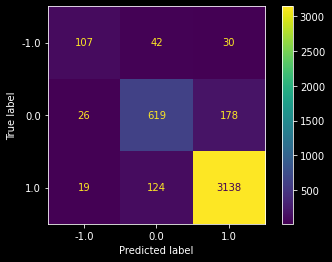

In [75]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

y_pred = mlp.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### Playground

In [76]:
mlp = pickle.load(open('../models/model.pkl', 'rb'))
vec_count = pickle.load(open('../models/vectorizer.pkl', 'rb'))


In [77]:
def preprocess_text(text):
  """
  Preprocess the text
  """
  text = clean_text(text)
  text = fix_spell(text)
  text = remove_stopwords(text)
  text = lemmatize(text)
  text = vec_count.transform([text]).toarray()
  
  return text
  

#### Playing the model

In [78]:
p_review = preprocess_text('The product is bad')

mlp.predict(p_review)

array([-1.])

In [79]:
p_review = preprocess_text('The product is okay')

mlp.predict(p_review)

array([0.])

In [80]:
p_review = preprocess_text('The product is good')

mlp.predict(p_review)

array([1.])

In [81]:
def predict_review(text):
  """
  Predict the review
  """
  text = preprocess_text(text)
  return mlp.predict(text)
